# OpenAI Gym -- Solved Lunar Lander using DeepRL

Solution for OpenAI Gym's Lunar Lander environment using deep reeinforcement learning.
(C) 2022 Manfred SCHLAEGL <manfred.schlaegl@gmx.at>

Code based on OpenAI_Gym_Cartpole_deepRL.ipynb
(originally inspired by [(527) Deep Q-Network Training Code - Reinforcement Learning Code Project - YouTube](https://www.youtube.com/watch?v=ewRw996uevM&list=PLZbbT5o_s2xoWNVdDudn51XM8lOuZ_Njv&index=18))

OpenAI Gym Lunar Lander Environment: https://www.gymlibrary.ml/environments/box2d/lunar_lander

## Requirements
 * Standard python packages (numpy, ...)
 * Matplolib: pip install Matplotlib
 * OpenAI Gym: pip install gym[all]
 * Pygame: pip install pygame
 * PyTorch: pip install torch
 * PyTorch Torchvision: pip install torchvision

## Implementation

### Imports and Global Settings

In [1]:
%matplotlib inline
#from gym import wrappers
import math
import random
import numpy as np
from os.path import exists
import matplotlib
import matplotlib.pyplot as plt
import gym
from collections import namedtuple
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

/opt/jupyternotebook/virtualenv/lib/python3.8/site-packages/torchvision/transforms/functional_pil.py:228: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  interpolation: int = Image.BILINEAR,
/opt/jupyternotebook/virtualenv/lib/python3.8/site-packages/torchvision/transforms/functional_pil.py:295: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  interpolation: int = Image.NEAREST,
/opt/jupyternotebook/virtualenv/lib/python3.8/site-packages/torchvision/transforms/functional_pil.py:328: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  interpolation: int = Image.BICUBIC,


In [2]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display
torchdevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Framework

#### DQN: Model for policy (and target) network

In [3]:
# DQN extends nn.Module
class DQN(nn.Module):

    def __init__(self, n_inputs, n_outputs):
        """
        model constructor

        :param n_inputs: number of inputs
        :param n_outputs: number of outputs
        """ 
        super().__init__()
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.fc1 = nn.Linear(in_features=n_inputs, out_features=48)
        self.out = nn.Linear(in_features=48, out_features=n_outputs)

    
    # overloaded
    def forward(self, inputs):
        t = inputs.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = self.out(t)
        return t

    
    def clone(self, torchdevice):
        """
        clone this model

        :torchdevice:
        :return: clone of current model
        """
        clone = DQN(self.n_inputs, self.n_outputs).to(torchdevice)
        clone.load_state_dict(self.state_dict())
        return clone
    
    
    def save(self, filename):
        """
        save the model to given file

        :filename: file to save the model to
        """ 
        torch.save(self.state_dict(), filename)
        

    def load(self, filename):
        """
        load the model from given file

        :filename: file to save the model to
        :return: False if file does not exist
        """
        if not exists(filename):
            return False
        
        self.load_state_dict(torch.load(filename))
        return True

#### Replay Memory for Experience Replay


In [4]:
# python tuple with named fields
Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward')
)

class ReplayMemory():
    def __init__(self, capacity):
        """
        initialize with given capacity

        :capacity: capacity of the ReplayMemory
        """
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
        self.push_idx = 0
       
    
    def push(self, experience):
        """
        push a new experience
        if the memory is full we push in round robin fashion

        :experience: Experience to push
        """
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_idx] = experience
        self.push_idx += 1
        if self.push_idx >= self.capacity:
            self.push_idx = 0
        self.push_count += 1
        
        
    def nElements(self):
        """
        Number of experiences in ReplayMemory

        :return: number of experiences in ReplayMemory
        """
        return len(self.memory)
        
        
    def can_provide_sample(self, batch_size):
        """
        Enough experiences in ReplayMemory to return batch_size

        :batch_size: size of the batch
        :return: True if number of experiences > batch_size
        """
        return self.nElements() >= batch_size
    
    
    def sample(self, batch_size):
        """
        get a random batch of experiences

        :batch_size: size of the batch
        :return: random batch (None if not enough samples)
        """
        if not self.can_provide_sample(batch_size):
            return None
        return random.sample(self.memory, batch_size)

#### Agent (and Action Selection Strategies)

In [5]:
# Epsilon Greedy Strategy (for Training)
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
        
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * \
            math.exp(-1. * current_step * self.decay)

# Exploitation Strategy (for Playing)
class ExploitationStrategy():
    def get_exploration_rate(self, current_step):
        return 0


# Agent (Action Selection)
class Agent():
    def __init__(self, torchdevice, strategy, n_actions):
        self.current_step = 0
        self.strategy = strategy
        self.n_actions = n_actions
        self.torchdevice = torchdevice
        
    def select_action(self, state, policy_net):
        """
        select action w.r.t. given state and configured
        strategy

        :state: current state
        :policy_net: the policy network
        :return: action
        """
        rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step += 1
        
        if rate > random.random():
            #print('explore')
            action = random.randrange(self.n_actions)
            return torch.tensor([action]).to(self.torchdevice)
        else:
            #print('exploit')
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).to(self.torchdevice)

#### Lunar Lander Environment Handling

In [26]:
class LunarLanderEnvManager():
    def __init__(self, torchdevice, enable_wind=False):
        self.torchdevice = torchdevice
        # unwrapped gives access to behind the scene elements of env
        self.env = gym.make('LunarLander-v2', enable_wind=enable_wind).unwrapped
        self.reset()
        
    def reset(self):
        self.env.reset()
        self.state = None
        self.done = False
        
    def close(self):
        self.env.close()
        
    def render(self, mode='human'):
        return self.env.render(mode)
    
    def n_observations(self):
        return self.env.observation_space.shape[0]
    
    def n_actions(self):
        return self.env.action_space.n
    
    def take_action(self, action):
        """
        perform action and return reward

        :action: action to take
        :return: reward
        """
        # action is tensor -> item delivers value of tensor as python number
        self.state, reward, self.done, _ = self.env.step(action.item())
        return torch.tensor([np.float32(reward)], device=self.torchdevice)

    def get_state(self):
        if self.state is None or self.done:
            # no action was done before
            ret=torch.zeros(self.n_observations())
        else:
            ret=torch.tensor(self.state, device=self.torchdevice)
        return ret.unsqueeze(0).to(self.torchdevice)

#### QValue calculation

In [7]:
class QValues():
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
    
    @staticmethod
    def get_next(target_net, next_states):
        # handling of final states
        final_state_locations = next_states.flatten(start_dim=1) \
            .max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(torchdevice)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values

#### Misc Helper Functions

In [8]:
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()
    plt.title('Performance ...')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(values)
    
    moving_avg = get_moving_average(values, moving_avg_period)
    plt.plot(moving_avg)
    plt.pause(0.001)
    print("Episode " + str(len(values)) + 
          " with average reward " + str(moving_avg[-1]))

def plot_results(values, moving_avg_period):
    episode_best = np.argmax(values)
    moving_avg_best = np.max(values).item()
    plot(values, moving_avg_period)
        
def get_moving_average(values, period):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) < period:
        moving_avg = torch.full((len(values), ), float('-inf'))
        return moving_avg.numpy()
    
    # periode slice and mean
    moving_avg = values.unfold(dimension=0, size=period, step=1) \
        .mean(dim=1).flatten(start_dim=0)
    moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
    return moving_avg.numpy()

def extract_tensors(experiences):
    batch = Experience(*zip(*experiences))
    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)
    return (t1, t2, t3, t4)

### Application

In [9]:
# Hyper Parameters for Training
class HyperParameters():
    def __init__(self):
        
        # size of replay memory for experience replay
        self.memory_size = 100000
        
        # batch_size (taken from replay memory)
        self.batch_size = 256
        
        # RL gamma
        self.gamma = 0.999
        
        # exploration rate (start, end, decay)
        self.eps_start = 1
        self.eps_end = 0.01
        self.eps_decay = 0.0001
        
        # episodes after which target_net = policy_net
        self.target_update = 10
        
        # learning rate
        self.lr = 0.001
        
        # number of episodes
        self.n_episodes = 5000
        
        # maximum number of timesteps to play
        self.max_timestep = 500
        
        # number of episodes used to calculate moving reward average
        self.n_episodes_ravg = 100

In [10]:
def load(torchdevice, em, filename):
    """
    load a policy network from given file

    :torchdevice: torch.device(...)
    :em: the environment the model was trained on
    :filename: filename
    :return: polcy network (None if file not found)
    """

    policy_net = DQN(
        em.n_observations(),
        em.n_actions()).to(torchdevice)
    if not policy_net.load(filename):
        return None
    return policy_net

In [11]:
def train(torchdevice, em, hpara, stat_update = 100, policy_net = None):
    """
    train a policy network with given parameters

    :torchdevice: torch.device(...)
    :em: the environment to train on
    :filename: filename
    :stat_update: plot statistics after every stat_update episodes (default 100)
    :policy_net: optional existing model to train (default None)
    :return: (best found policy network, episode rewards)
    """
        
    # setup agent
    agent = Agent(
        torchdevice,
        EpsilonGreedyStrategy(
            hpara.eps_start,
            hpara.eps_end,
            hpara.eps_decay),
        em.n_actions())
    
    # setup replay memory (for experience replay)
    memory = ReplayMemory(hpara.memory_size)

    # create new policy_net (if not given)
    if policy_net == None:
        policy_net = DQN(
            em.n_observations(),
            em.n_actions()).to(torchdevice)
    policy_net.train() # switch to training mode
    
    # create target net
    target_net = policy_net.clone(torchdevice)
    target_net.eval() # only inference
    
    # setup optimizer
    optimizer = optim.Adam(params=policy_net.parameters(), lr=hpara.lr)
    
    # track best episode
    moving_avg_best = float('-inf')
    episode_best = 0
    policy_net_best = policy_net.clone(torchdevice)
    policy_net_best.eval() # only inference    
    
    # track episode rewards
    episode_rewards = []
    
    # start training
    print("0: ", end='')
    for episode in range(1, hpara.n_episodes + 1):

        # start new episode
        print(".", end='')
        em.reset()
        
        state = em.get_state()
        reward_sum = 0
        for timestep in count():
            
            # make a move
            action = agent.select_action(state, policy_net)
            reward = em.take_action(action)
            reward_sum += reward
            next_state = em.get_state()
            memory.push(Experience(state, action, next_state, reward))

            state = next_state

            # start training, after we have enough samples in replay memory
            if memory.can_provide_sample(hpara.batch_size):
                
                # get batch of experiences
                experiences = memory.sample(hpara.batch_size)
                states, actions, rewards, next_states = extract_tensors(experiences)

                # calculate qvalues and loss
                current_q_values = QValues.get_current(policy_net, states, actions)
                next_q_values = QValues.get_next(target_net, next_states)
                target_q_values = (next_q_values * hpara.gamma) + rewards
                loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
                
                # pytorch saves grad of w and bias
                optimizer.zero_grad()
                # computes gradient w.r.t to bias and weights
                loss.backward()
                # update weight and bias from backward (connection to loss?)
                optimizer.step()

            
            # end of episode?
            if em.done or timestep >= hpara.max_timestep:
                # statistics
                episode_rewards.append(reward_sum)

                #
                # Save the best performing model
                #
                # We observed, that the performance of the agent does not
                # converge. It's performance fluctuates strongly over the
                # training cycle. This means, that there is no guarantee,
                # that the model at the end of the training is the best
                # performing one.
                # Solution: We keep track of the best performing model
                # while in training.
                #
                # We save the model if these two conditions are met:
                # 1. If the model performed well in the last few 
                #    episodes
                #    -> If the moving average of reward is better than
                #       what we have seen so far.
                # 2. To prevent saving a bad performing outlier: If the
                #    model performed well in the last episode
                #    -> If the last episodes reward is better or equal
                #       than the moving average

                moving_avg = get_moving_average(
                    episode_rewards,
                    para.n_episodes_ravg)[-1]
                if moving_avg > moving_avg_best and reward_sum >= moving_avg_best:
                    moving_avg_best = moving_avg
                    episode_best = episode
                    policy_net_best.load_state_dict(policy_net.state_dict())
                    print("\nsave best: Episode " + str(episode_best) +
                          " with average reward " + str(moving_avg_best));

                # update target_net
                if episode % hpara.target_update == 0:
                    target_net.load_state_dict(policy_net.state_dict())
    
                # output statistics
                if episode % stat_update == 0:
                    if is_ipython: display.clear_output(wait=True)
                    plot(episode_rewards, para.n_episodes_ravg)
                    print("best: Episode " + str(episode_best) +
                          " with average reward " + str(moving_avg_best));
                    print(str(episode) + ": ", end='')

                break

    # return best policy and statistics
    
    print("best: Episode " + str(episode_best) +
          " with average reward " + str(moving_avg_best));
    policy_net_best.eval() # only inference    
    return (policy_net_best, episode_rewards)

In [12]:
def play(torchdevice, em, policy_net,
         n_episodes_ravg = 100,
         num_episodes = 1, 
         max_timestep = 1000):
    """
    play the game using a given policy network

    :torchdevice: torch.device(...)
    :em: the environment to play on
    :policy_net: policy network to use
    :num_episodes: number of episodes to play (default 1)
    :max_timestep: maximum timesteps to play (default 1000)
    :n_episodes_ravg: number of episodes used to calculate moving reward average (for plot) (default 100)
    :return: episode rewards
    """
        
    # setup agent
    agent = Agent(torchdevice,
                  ExploitationStrategy(),
                  em.n_actions())

    # track episode rewards
    episode_rewards = []

    for episode in range(1, num_episodes + 1):

        # start new episode
        em.reset()

        # play
        state = em.get_state()
        reward_sum = 0
        for timestep in count():

            # render output
            em.render()

            # make a move
            action = agent.select_action(state, policy_net)
            reward_sum += em.take_action(action)
            state = em.get_state()

            # end of episode?
            if em.done or timestep >= max_timestep:
                episode_rewards.append(reward_sum)
                if is_ipython: display.clear_output(wait=True)
                print("Episode " + str(episode) +
                      " with reward " + str(reward_sum.item()));

                plot(episode_rewards, n_episodes_ravg)
                break
        
    return episode_rewards

### Main Program
If the model file exists and is loadable -> play. If the model file does not exist -> train, save & play

In [13]:
# model file to load
modelfile="OpenAI_Gym_LunarLander_deepRL.model"

# the environment to train/play
em = LunarLanderEnvManager(torchdevice)

/opt/jupyternotebook/virtualenv/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


In [14]:
# try loading model
policy_net = load(torchdevice, em, modelfile)

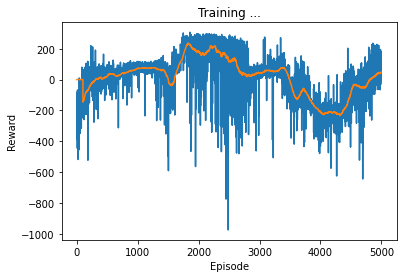

Episode 5000 with average reward 48.69304
best: Episode 1824 with average reward 237.19809
5000: best: Episode 1824 with average reward 237.19809
Best episode: 1855 with average reward 306.72369384765625


/opt/jupyternotebook/virtualenv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:43: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = getattr(asarray(obj), method)(*args, **kwds)
/opt/jupyternotebook/virtualenv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*ar

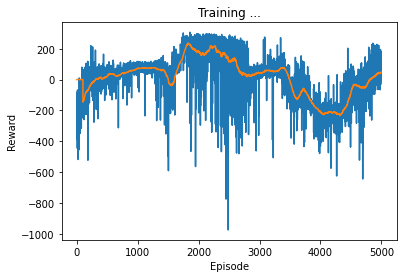

Episode 5000 with average reward 48.69304


In [15]:
# if model could not be loaded -> train & save
episode_rewards = None
para = HyperParameters()
if policy_net is None:
    policy_net, episode_rewards = train(torchdevice, em, para, 10)
    policy_net.save(modelfile)
    plot_results(episode_rewards, para.n_episodes_ravg)

Episode 5 with reward 262.96343994140625


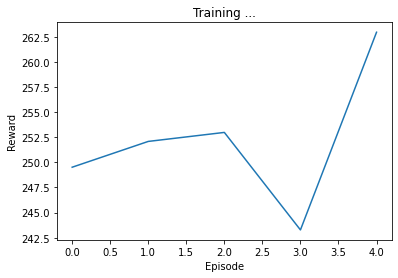

Episode 5 with average reward -inf


In [16]:
# play
episode_rewards = play(torchdevice, em, policy_net, para.n_episodes_ravg, 5, 1000)

Best episode: 4 with average reward 262.96343994140625


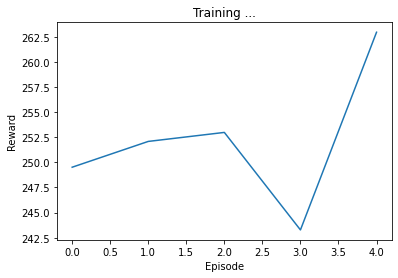

Episode 5 with average reward -inf


In [17]:
# print results of play
if episode_rewards is not None:
    plot_results(episode_rewards, para.n_episodes_ravg)

Episode 5 with reward 123.51409149169922


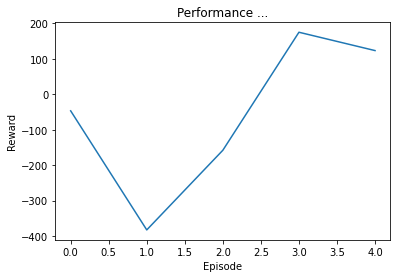

Episode 5 with average reward -inf


In [35]:
# play with wind (not trained!)
em_wind = LunarLanderEnvManager(torchdevice, True)
episode_rewards_wind = play(torchdevice, em_wind, policy_net, para.n_episodes_ravg, 5, 1000)

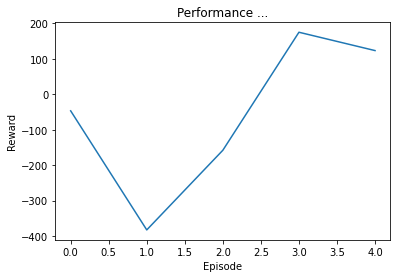

Episode 5 with average reward -inf


In [36]:
# print results of play with wind
if episode_rewards_wind is not None:
    plot_results(episode_rewards_wind, para.n_episodes_ravg)